# Import dependencies

1. Descargamos las librerías necesarias para la realización del script:

In [ ]:
################  TRANSFORMERS ################
!pip  install transformers --quiet
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import Trainer, TrainingArguments
from transformers import Trainer
!pip install transformers[torch] --quiet
!pip install accelerate -U --quiet
################  DATASETS ################
!pip install Datasets --quiet
from datasets import DatasetDict, Dataset
# Librería para montar drive en GoogleColab y descargar el dataset que vamos a usar:
from google.colab import drive  #Montador de drive
################  Spacy ################
!pip install spacy -- quiet
import spacy
from spacy.lang.es.examples import sentences
!python -m spacy download es_core_news_sm
nlp = spacy.load("es_core_news_sm")

ERROR: Could not find a version that satisfies the requirement quiet (from versions: none)
ERROR: No matching distribution found for quiet
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 39.8 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
# Importamos otros modulos que necesitaremos para nuestra aproximación:
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('omw-1.4')
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
################  MÉTRICAS ################
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Librería usada para la división del conjunto de datos en 3 conjuntos (Entrenamiento, Validación y Test)
from sklearn.model_selection import train_test_split
import gc

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


# 2. Importamos el dataset

In [ ]:
# 1.Obtenemos de drive el dataframe con el que vamos a trabajar
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/MyDrive/datasets/01 Exist2021_Esp.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df.head()

,test_case,id,source,language,text,task1,task2
0,EXIST2021,1,twitter,es,Nadie te va a tratar tan bien como un hombre q...,sexist,sexual-violence
1,EXIST2021,2,twitter,es,"@lindagisela74 Que rica putita obediente, afor...",sexist,stereotyping-dominance
2,EXIST2021,3,twitter,es,@BicireporteraDF Yo lo hice a los 18 años por ...,non-sexist,non-sexist
3,EXIST2021,4,twitter,es,las cosas q sueño son indicios de que yo enrea...,non-sexist,non-sexist
4,EXIST2021,5,twitter,es,"Pero a la niña le gustó desde que lo vió, así ...",non-sexist,non-sexist


In [ ]:
# 2. Cambiamos el nombre de las columnas e eliminamos aquellas que no necesitamos:
columns_to_remove = ['test_case', 'id', 'source','language','task1']
df = df.rename(columns = {"task2": "label"}).drop(columns=columns_to_remove, axis=1)
df.head()

,text,label
0,Nadie te va a tratar tan bien como un hombre q...,sexual-violence
1,"@lindagisela74 Que rica putita obediente, afor...",stereotyping-dominance
2,@BicireporteraDF Yo lo hice a los 18 años por ...,non-sexist
3,las cosas q sueño son indicios de que yo enrea...,non-sexist
4,"Pero a la niña le gustó desde que lo vió, así ...",non-sexist


In [ ]:
#Cambiamos los valores nominales de sexista y no sexista a valores numéricos
df['label'] = df['label'].replace(['non-sexist','sexual-violence', 'stereotyping-dominance',
 'misogyny-non-sexual-violence' ,'ideological-inequality', 'objectification'],[0,1,2,3,4,5])

In [ ]:
#4. Eliminamos cualquier fila que haya podido quedar en blanco:
df = df.dropna()

In [ ]:
df.head()

,text,label
0,Nadie te va a tratar tan bien como un hombre q...,1
1,"@lindagisela74 Que rica putita obediente, afor...",2
2,@BicireporteraDF Yo lo hice a los 18 años por ...,0
3,las cosas q sueño son indicios de que yo enrea...,0
4,"Pero a la niña le gustó desde que lo vió, así ...",0


# Funciones preprocesamiento

In [ ]:
def preprocess(text_string):
    """
    Accepts a text string and replaces:
    1) urls with URLHERE
    2) lots of whitespace with one instance
    3) mentions with MENTIONHERE
    This allows us to get standardized counts of urls and mentions
    Without caring about specific people mentioned
    """
    space_pattern = '\s+'
    giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention_regex = '@[\w\-]+'
    parsed_text = re.sub(space_pattern, ' ', text_string)
    parsed_text = re.sub(giant_url_regex, 'URLHERE', parsed_text)
    parsed_text = re.sub(mention_regex, 'MENTIONHERE', parsed_text)
    #parsed_text = parsed_text.code("utf-8", errors='ignore')
    return parsed_text


In [ ]:
stopword_es = nltk.corpus.stopwords.words('spanish')

In [ ]:
def remove_stopwords(text):
    stop_words = set(stopword_es)  # Usa stopwords en español
    tokens = word_tokenize(text)  # Tokeniza el texto de entrada
    filtered_sentence = [word for word in tokens if word not in stop_words]  # Filtra las stopwords

    return ' '.join(filtered_sentence)  # Une las palabras filtradas en una cadena

In [ ]:
def lematizador(text):
  doc = nlp(text)
  return ' '.join([word.lemma_ for word in doc])

In [ ]:
len(stopword_es)

313

In [ ]:
import re

In [ ]:
df['text'] = df['text'].apply(preprocess)

In [ ]:
df['text'] = df['text'].apply(remove_stopwords)

In [ ]:
df['text'] = df['text'].apply(lematizador)

### 2.1 - *Separamos el dataset en varios conjuntos (Train, Validación y Test)*

In [ ]:
# Dividiremos el dataset en el 80% para el entrenamiento, el 10% para el proceso de validation, y un 10% para testear los resultados del modelo.
train_df, valtest_df = train_test_split(df, test_size = 0.2, random_state = 42)
val_df, test_df = train_test_split(valtest_df, test_size = 0.5, random_state = 42)
train_df.shape, val_df.shape, test_df.shape

((9063, 2), (1133, 2), (1133, 2))

In [ ]:
train = Dataset.from_pandas(train_df)
validation = Dataset.from_pandas(val_df)
test = Dataset.from_pandas(test_df)

In [ ]:
#Lo convertimos en un solo dataset:

tweets = DatasetDict({
  'train': train,
  'val': validation,
  'test': test})
# Dataset.from_pandas genera una columna denominada index_0 qeu debemos eliminar:

tweets = tweets.remove_columns(["__index_level_0__"])

In [ ]:
tweets

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 9063
    })
    val: Dataset({
        features: ['text', 'label'],
        num_rows: 1133
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 1133
    })
})

### 3 - Descarga del modelo y su tokenizador:

In [ ]:
#Especificamos el modelo a adaptar a nuestro problema:
model_ckpt =  'sdadas/xlm-roberta-large-twitter'
# y descargamos su tokenizador:
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
#Debemos definir una función para tokenizar el dataset y que sea gestionable por nuestro modelo:
def tokenizador(batch):
  return tokenizer( batch["text"], padding = True,  max_length=512, truncation = True)

In [ ]:
# Para poder aplicarlo al todo el diccionario utilizaremos la función map:
tweets_Encoded = tweets.map(tokenizador, batched = True,batch_size = None )

Map:   0%|          | 0/9063 [00:00<?, ? examples/s]

Map:   0%|          | 0/1133 [00:00<?, ? examples/s]

Map:   0%|          | 0/1133 [00:00<?, ? examples/s]

In [ ]:
tweets_Encoded

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 9063
    })
    val: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 1133
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 1133
    })
})

In [ ]:
#Ahora que hemos codificado el texto, lo eliminamos de nuestro diccionarios ya que no es necesario:
#tweets_Encoded = tweets_Encoded.remove_columns(['text'])

In [ ]:
#Necesitamos que los objetos sean de tipo torch
tweets_Encoded.set_format("torch", columns = ["label","input_ids", "attention_mask"])

In [ ]:
#Debemos comprobar que la ejecucion se vaya a realizar sobre cuda:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Definiremos un diccionario para poder traduccir las etiquetas o labels que nos devuelva nuestro modelo:
Etiqueta_dato = {}
Dato_Etiqueta = {}

etiquetas = ['non-sexist','sexual-violence', 'stereotyping-dominance',
 'misogyny-non-sexual-violence' ,'ideological-inequality', 'objectification']
for dato, nombre_etiqueta in enumerate(etiquetas):
  Dato_Etiqueta[nombre_etiqueta] = str(dato)
  Etiqueta_dato[str(dato)]= nombre_etiqueta


Etiqueta_dato , Dato_Etiqueta

({'0': 'non-sexist',
  '1': 'sexual-violence',
  '2': 'stereotyping-dominance',
  '3': 'misogyny-non-sexual-violence',
  '4': 'ideological-inequality',
  '5': 'objectification'},
 {'non-sexist': '0',
  'sexual-violence': '1',
  'stereotyping-dominance': '2',
  'misogyny-non-sexual-violence': '3',
  'ideological-inequality': '4',
  'objectification': '5'})

In [ ]:
#Obtenemos el modelo con una cabeza de clasificación:
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels = 6, label2id = Etiqueta_dato, id2label = Dato_Etiqueta).to(device)

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at sdadas/xlm-roberta-large-twitter and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### 4. Definimos los hyperparametros:

In [ ]:
# 1. Definimos la función de evaluación para calcular tanto el f1 como el accuracy:
def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  f1 = f1_score(labels, preds, average = "weighted")
  acc = accuracy_score(labels, preds)
  return {"accuracy": acc, "f1": f1}

In [ ]:
#2. Definimos los hiperparametros para el entrenamiento:
#Empezamos con un batchsize y un número de épocas aleatorio:
batch_size = 8
num_epochs = 3

# Name of the model (to be uploaded to Huggingface)
model_name = f"{model_ckpt}-finetuned-taskB_2ªiter"

# Specify the path to store the fine-tuned model
path_model = '/content/drive/MyDrive/'

# Training argument
training_args = TrainingArguments(
  output_dir = os.path.join(path_model, model_name),
  num_train_epochs = num_epochs,
  learning_rate = 2e-5,
  per_device_train_batch_size = batch_size,
  per_device_eval_batch_size = batch_size,
  weight_decay = 0.01,
  evaluation_strategy = "epoch",
  load_best_model_at_end = True,
  push_to_hub = False,
  save_strategy = "epoch")

In [ ]:
# Entrenemos el modelo con la API Trainer:
trainer = Trainer(
  model = model,
  args = training_args,
  compute_metrics = compute_metrics,
  train_dataset = tweets_Encoded["train"],
  eval_dataset = tweets_Encoded["val"],
  tokenizer = tokenizer)

In [ ]:
gc.collect()
torch.cuda.empty_cache()

In [ ]:
#5.Entrenamos nuestro modelo:
trainer.train()


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,1.016900,0.979430,0.639894,0.639002
2,0.757600,0.990910,0.658429,0.655841
3,0.473600,1.134661,0.657546,0.654609


TrainOutput(global_step=3399, training_loss=0.7826755767220713, metrics={'train_runtime': 4691.9684, 'train_samples_per_second': 5.795, 'train_steps_per_second': 0.724, 'total_flos': 2.533862428841779e+16, 'train_loss': 0.7826755767220713, 'epoch': 3.0})

### Matriz de Confusión

In [ ]:
preds_output = trainer.predict(tweets_Encoded["val"])

In [ ]:
preds_output.metrics

{'test_loss': 0.9794300198554993,
 'test_accuracy': 0.6398940864960282,
 'test_f1': 0.6390024927081347,
 'test_runtime': 18.1395,
 'test_samples_per_second': 62.46,
 'test_steps_per_second': 7.828}

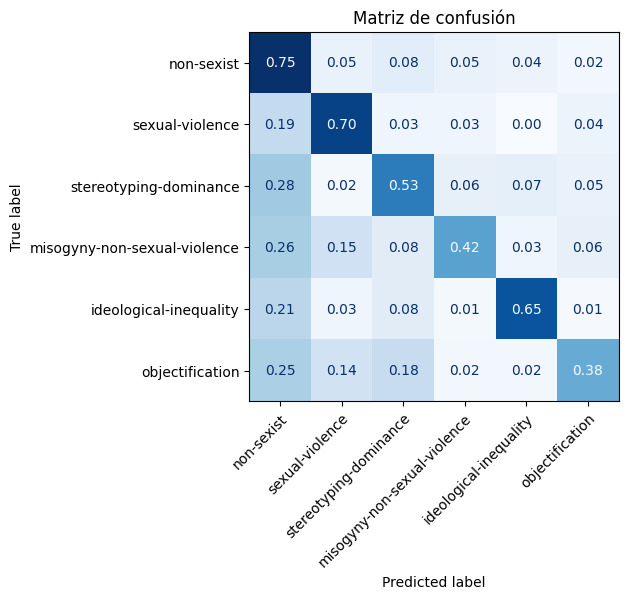

In [ ]:
y_preds = np.argmax(preds_output.predictions, axis=1)
cm = confusion_matrix(tweets_Encoded["val"]['label'], y_preds, normalize="true")
labels = ['non-sexist', 'sexual-violence', 'stereotyping-dominance', 'misogyny-non-sexual-violence', 'ideological-inequality', 'objectification']
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
# Crear una figura y un eje
fig, ax = plt.subplots()
# Plotear la matriz de confusión
disp.plot(cmap="Blues", values_format=".2f", colorbar=False, ax=ax)

# Ajustar las etiquetas de la línea x
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

plt.title("Matriz de confusión")
plt.show()

In [ ]:
preds_output = trainer.predict(tweets_Encoded["test"])
preds_output.metrics



{'test_loss': 0.9633265733718872,
 'test_accuracy': 0.6610767872903796,
 'test_f1': 0.6598449222938266,
 'test_runtime': 16.3863,
 'test_samples_per_second': 69.143,
 'test_steps_per_second': 8.666}

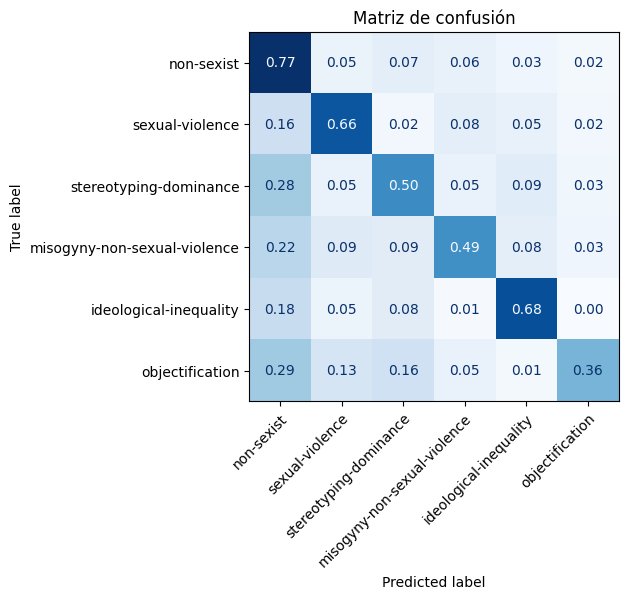

In [ ]:
y_preds = np.argmax(preds_output.predictions, axis=1)
cm = confusion_matrix(tweets_Encoded["test"]['label'], y_preds, normalize="true")
labels = ['non-sexist', 'sexual-violence', 'stereotyping-dominance', 'misogyny-non-sexual-violence', 'ideological-inequality', 'objectification']
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
# Crear una figura y un eje
fig, ax = plt.subplots()
# Plotear la matriz de confusión
disp.plot(cmap="Blues", values_format=".2f", colorbar=False, ax=ax)

# Ajustar las etiquetas de la línea x
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

plt.title("Matriz de confusión")
plt.show()

# Guardamos el modelo:


In [ ]:
model.save_pretrained(
  os.path.join(path_model, 'distilbert-base-uncased-finetuned-detección-sexismo'))
tokenizer.save_pretrained(
    os.path.join(path_model, 'distilbert-base-uncased-finetuned-detección-sexismo'))

('/content/drive/MyDrive/distilbert-base-uncased-finetuned-detección-sexismo/tokenizer_config.json',
 '/content/drive/MyDrive/distilbert-base-uncased-finetuned-detección-sexismo/special_tokens_map.json',
 '/content/drive/MyDrive/distilbert-base-uncased-finetuned-detección-sexismo/sentencepiece.bpe.model',
 '/content/drive/MyDrive/distilbert-base-uncased-finetuned-detección-sexismo/added_tokens.json',
 '/content/drive/MyDrive/distilbert-base-uncased-finetuned-detección-sexismo/tokenizer.json')

# Análisis del validation loss

In [ ]:
#Análisis de la perdida del modelo:

from torch.nn.functional import cross_entropy

def forward_pass_with_label(batch):
    # Place all input tensors on the same device as the model
    inputs = {k:v.to(device) for k,v in batch.items()
              if k in tokenizer.model_input_names}

    with torch.no_grad():
        output = model(**inputs)
        pred_label = torch.argmax(output.logits, axis=-1)
        loss = cross_entropy(output.logits, batch["label"].to(device),
                             reduction="none")
    # Place outputs on CPU for compatibility with other dataset columns
    return {"loss": loss.cpu().numpy(),
            "predicted_label": pred_label.cpu().numpy()}

In [ ]:
tweets_Encoded["val"] = tweets_Encoded["val"].map(forward_pass_with_label, batched=True, batch_size=16)

Map:   0%|          | 0/1133 [00:00<?, ? examples/s]

In [ ]:
def label_int2str(label):
    return Etiqueta_dato[str(label)]

In [ ]:
tweets_Encoded.set_format("pandas")
cols = ["text", "label", "predicted_label", "loss"]
df_test = tweets_Encoded["val"][:][cols]
df_test["label"] = df_test["label"].apply(label_int2str)
df_test["predicted_label"] = (df_test["predicted_label"]
                              .apply(label_int2str))

In [ ]:
from IPython.display import display
pd.set_option('display.max_colwidth', None)

In [ ]:
df_test.sort_values("loss", ascending=False).head(10)

,text,label,predicted_label,loss
215,MENTIONHERE MENTIONHERE MENTIONHERE ser táctico clásico usado mujer milenio debilitarla reduciéndola objeto . así desvarío feminista .. no feminismir malo . alguno observación seguir ser válir incluso ahora,objectification,ideological-inequality,5.189180
43,"sí , saber borracho seguir ser Killary , esperar hígado entregue .",misogyny-non-sexual-violence,non-sexist,5.010945
148,haber grave problema Susan Rice ser capaz postular él cualquiera oficina . que todavía mujer libre .,misogyny-non-sexual-violence,non-sexist,5.009748
1054,"Ejem , ejem ... uno hombre sirio cuatro mujer 23 hijo cobrar 30000 € mes sistema social alemán . haber saber montar saber ?",objectification,non-sexist,4.885064
751,MENTIONHERE hey chico tonto MENTIONHERE siquiera saber si religión todavía allí sólo deber sri guru teg bahadur ji morir religión hindu decir terrorista realmente querer dividir nación ! ! vergüenza,stereotyping-dominance,non-sexist,4.817800
101,"MENTIONHERE MENTIONHERE Que bueno necesario mostrar teta , cagar calle andar raja pelo ser igual",ideological-inequality,objectification,4.691428
494,"` ` ya divertí '' '' ya querer juegos '' siempre mismo . el alfa primero , luego beta dinero . # mgtow URLHERE",stereotyping-dominance,non-sexist,4.618960
847,MENTIONHERE MENTIONHERE MENTIONHERE no culpo absoluto . yo tampoco querer ir allí . parecer período mujer & amp ; niño seguro allí .,misogyny-non-sexual-violence,non-sexist,4.602499
306,MENTIONHERE REGORDETA FEA HIPÓCRITA el basura,objectification,non-sexist,4.491219
179,"# NoEsBromaY si suficiente , pagar pensión alimenticio ... URLHERE",ideological-inequality,non-sexist,4.461054


In [ ]:
df_test.sort_values("loss", ascending=True).head(10)

,text,label,predicted_label,loss
820,"si sa él hacer cosa buena sucedar , llenarás esperanza mundo mismo – Barack Obama¿Y si intenta ? Atrévete , visítano URLHERE # Sanaccion # BarackObama # bueno # esperanza # mundo # Felicidad # Iluminación # Empoderamiento # crecimiento URLHERE",non-sexist,non-sexist,0.011538
187,"¡ el COMPROMISO DE HACER MEJOR ! hoy celebrar día Internacional Voluntariado , él querer saludar afectuosamente hombre mujer , formar parte ONG ' s Provincia , trabajar emergencia . URLHERE",non-sexist,non-sexist,0.013042
787,"# PixarSoul arte : abstracta sencillo vez , momento divertido dulce , momento ácido triste . uno viaje emocional emocionante dudar merecer reconocimiento mejor película animación año .",non-sexist,non-sexist,0.016373
244,MENTIONHERE Por favor hacer trending copia hashtag posts alcance # AZTECANOTICAS # TELEMUNDO # noticierostelevisa # TELEDIARIO # PFPapoya # pgj # GobiernoDelEstado # PFP # PGR # CNDH # yositecreo # niunameno # CIDH # CDMX # SEDENA # GuardiaNacional,non-sexist,non-sexist,0.016474
1089,MENTIONHERE Por favor hacer trending copia hashtag posts alcance # AZTECANOTICAS # TELEMUNDO # noticierostelevisa # TELEDIARIO # PFPapoya # pgj # GobiernoDelEstado # PFP # PGR # CNDH # yositecreo # niunameno # CIDH # CDMX # SEDENA # GuardiaNacional,non-sexist,non-sexist,0.016474
707,hoy celebrir 16 año desarrollar estrategia exitoso # MarketingDigital # inboundmarketing client . gracias confiar # LaManada sigar crecer mano . ¡ ir año ! # Aniversario # Monkeysolutions # Dare2BeThere # Estrategias URLHERE,non-sexist,non-sexist,0.016483
377,"MENTIONHERE Mi Coronel . para sumerced Feliz Navidad , mucho salud prosperidad infinito . Dios Todopoderoso saber Ud buen hombre , necesitar patria .",non-sexist,non-sexist,0.017879
393,resultar hoy día juventud quedar felicitar único merecer . feliz día Gai ! llamar juventud nunca apagar : ),non-sexist,non-sexist,0.018363
400,Hola mamitaaEspero día disfrut tuits diario pondré llegar sacar sonrisa . ser persona lindo visto largo año supera cumples cada meta . gracias permitir yo acompañartir año .,non-sexist,non-sexist,0.018621
905,"ser seguro decir 2020 año gran importancia histórico . ¡ Gracias compartir esperanza dar Jesucristo ayudar hombre , mujer niño hacer propio historia ! Disfrute Informe anual 2020 continuación . # historyinthemakingurlhere URLHERE",non-sexist,non-sexist,0.018624
